# Using halotools built-in correlation functions

Halotools has some extremely useful functions built in to calculate correlations. Here, I will focus on using the function for</br>
clustering (position-position), ED (orientation-position), and EE (orientation-orientation) correlations.</br></br>

To measure the clustering correlation (DD), halotools has the function tpcf (two-point correlation function) in halotools.mock_observables.</br>
Both ED and EE are included as ed_3d and ee_3d respectively in halotools.mock_observables.ia_correlations import ed_3d, ee_3d

In [1]:
# Basic imports to build the HOD
import numpy as np
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, SubhaloPhaseSpace, Zheng07Cens, Zheng07Sats
from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment, SubhaloAlignment
from halotools.empirical_models.phase_space_models.subhalo_based_models.subhalo_phase_space import alignment_inherited_subhalo_props_dict

# Import for getting the halocat
from halotools.sim_manager import CachedHaloCatalog

# Import correlation functions
from halotools.mock_observables.ia_correlations import ed_3d, ee_3d
from halotools.mock_observables import tpcf

# Import some helper libraries for visualizing things
import time
import matplotlib.pyplot as plt

In [2]:
# Eliminate halos with 0 for halo_axisA_x(,y,z)
def mask_bad_halocat(halocat):
    bad_mask = (halocat.halo_table["halo_axisA_x"] == 0) & (halocat.halo_table["halo_axisA_y"] == 0) & (halocat.halo_table["halo_axisA_z"] == 0)
    halocat._halo_table = halocat.halo_table[ ~bad_mask ]

In [3]:
halocat = CachedHaloCatalog(simname='bolplanck', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')
mask_bad_halocat(halocat)

## Make the Model

First, of course, we need to create the HOD model instance. See the "creating_a_mock.ipynb" if you need a tutorial on this.</br>
We will be using a SubhaoAlignment model for the satellites

In [4]:
# MODELS

# Alignment Strengths
satellite_alignment = 0.6
central_alignment = 0.8

# Central galaxy components
cens_occ_model = Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()
cens_orientation_model = CentralAlignment(central_alignment_strength=central_alignment)

# Satellite galaxy Components
sats_occ_model = Zheng07Sats()
prof_args = ("satellites", np.logspace(10.5, 15.2, 15))
sats_prof_model = SubhaloPhaseSpace(*prof_args, inherited_subhalo_props_dict=alignment_inherited_subhalo_props_dict)
sats_orientation_model = SubhaloAlignment(satellite_alignment_strength=satellite_alignment, halocat=halocat)

In [5]:
# Initially create the mock with SubhaloAlignment to overwrite the host information with subhalo
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model,
                                     centrals_orientation = cens_orientation_model,
                                     satellites_orientation = sats_orientation_model,
                                     model_feature_calling_sequence = (
                                     'centrals_occupation',
                                     'centrals_profile',
                                     'satellites_occupation',
                                     'satellites_profile',
                                     'centrals_orientation',
                                     'satellites_orientation')
                                    )

#seed=132358712
seed=None
model_instance.populate_mock(halocat, seed=seed)

/media/nvanalfen/T7/Northeastern/Research/my halotools/halotools/halotools/empirical_models/ia_models/ia_model_components.py:190: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/media/nvanalfen/T7/Northeastern/Research/my halotools/halotools/halotools/empirical_models/ia_models/ia_model_components.py:879: UserWarning: `satellite_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)


## Measure The Correlations

There are a number of things we can do. For the sake of looking at more capabilities, I will be looking at the central-satellite correlations.</br>
We can, of course, do all of the same things with all galaxies or any other choices for populations.

First, use the "gal_type" column to get a mask for the central galaxies. This will make our lives easier

In [6]:
central_mask = model_instance.mock.galaxy_table["gal_type"] == "centrals"

Next, we can get the positions and orientations. The orientations are stored as the x, y, and z components of the unit vector of the major axis.

In [7]:
sat_coords = np.array( [ model_instance.mock.galaxy_table[~central_mask]['x'],
                                model_instance.mock.galaxy_table[~central_mask]['y'],
                                model_instance.mock.galaxy_table[~central_mask]['z'] ] ).T
sat_orientations = np.array( [ model_instance.mock.galaxy_table[~central_mask]['galaxy_axisA_x'],
                                    model_instance.mock.galaxy_table[~central_mask]['galaxy_axisA_y'],
                                    model_instance.mock.galaxy_table[~central_mask]['galaxy_axisA_z'] ] ).T

cen_coords = np.array( [ model_instance.mock.galaxy_table[central_mask]['x'],
                                model_instance.mock.galaxy_table[central_mask]['y'],
                                model_instance.mock.galaxy_table[central_mask]['z'] ] ).T
cen_orientations = np.array( [ model_instance.mock.galaxy_table[central_mask]['galaxy_axisA_x'],
                                    model_instance.mock.galaxy_table[central_mask]['galaxy_axisA_y'],
                                    model_instance.mock.galaxy_table[central_mask]['galaxy_axisA_z'] ] ).T

Those are all very fast steps and now we have the values we want to measure the correlations from.</br>
Note that we have taken each column and transposed arrays of the values. This avoids issues when trying</br>
to cast multiple columns to an array.</br></br>

Now, we can just call the three correlation functions. For fun, I will also throw in a timing check to give an idea of how long</br>
this step usually takes.

As a quick variable name explanation, $\xi$ (xi) is the position-position correlation, $\omega$ (omega) is orientation-position,</br>
and $\eta$ (eta) is orientation-orientation</br></br>

Note that for tpcf, when two samples are passed, it returns three correlations:</br>
<ul>
    <li>The autocorrelation of sample 3</li>
    <li>The cross correlations between samples 1 and 2</li>
    <li>The autocorrelation of sample 2</li>
</ul>

In [8]:
# Get logarithmic radial bins
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

start = time.time()

censat_xi = tpcf(cen_coords, rbins, sat_coords, period=halocat.Lbox)
censat_omega = ed_3d( sat_coords, sat_orientations, cen_coords, rbins, period=halocat.Lbox )
censat_eta = ee_3d( sat_coords, sat_orientations, cen_coords, cen_orientations, rbins, period=halocat.Lbox )

print(f"{round(time.time()-start,2)} seconds for all three correlations on {len(cen_coords)} centrals and {len(sat_coords)} satellites")

1.45 seconds for all three correlations on 67808 centrals and 20774 satellites


So this step took longer than the others, but was still quite fast. For fun, let's visualize what we just got

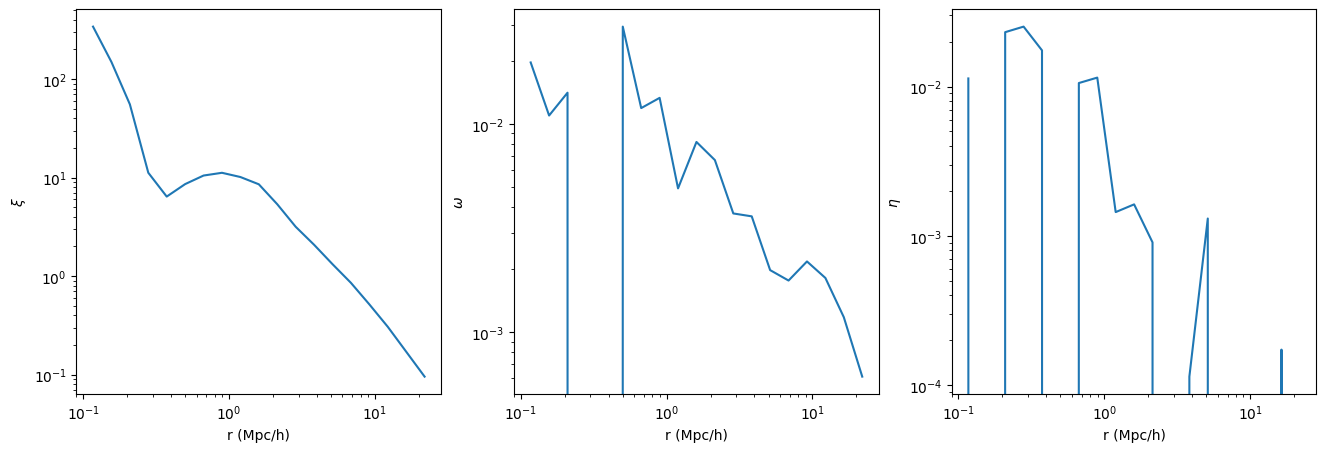

In [9]:
fig, axes = plt.subplots(1,3, figsize=(16,5))

axes[0].plot( rbin_centers, censat_xi[1] )
axes[0].set_xlabel("r (Mpc/h)")
axes[0].set_ylabel(r"$\xi$")
axes[0].set_xscale("log")
axes[0].set_yscale("log")

axes[1].plot( rbin_centers, censat_omega )
axes[1].set_xlabel("r (Mpc/h)")
axes[1].set_ylabel(r"$\omega$")
axes[1].set_xscale("log")
axes[1].set_yscale("log")

axes[2].plot( rbin_centers, censat_eta )
axes[2].set_xlabel("r (Mpc/h)")
axes[2].set_ylabel(r"$\eta$")
axes[2].set_xscale("log")
axes[2].set_yscale("log")

Of course, these don't look great. But that's a result of me choosing arbitrary and meaningless alignment strengths and not caring about much else.